
# Heteroskedastic Regression

In a standard Ordinary Least Squares (OLS) regression we assume homoskedasticity of the residuals. In case the residuals are normally distributed an OLS fit is equivalent to modelling the data as

$$Y|X \sim N(\beta X, \sigma^2)$$

I.e., conditioned on $X$ the response variable $Y$ is normally distributed with mean $\beta X$ and constanst variance $\sigma^2$. The parameters $\beta$ and $\sigma$ can be found using Maximum Likelihood Estimation (MLE), which in this particular case is equivalent to minimizing the sum of squared residuals.

There are several ways to deviate from this paradigm, two examples:

1. $Y|X$ could follow a different distribution, eg a gamma distribution if we're dealing with a positive response variable $Y$. For cases where the distribution is part of the exponential family we can leverage a [Generalized Linear Model (GLM)](https://en.wikipedia.org/wiki/Generalized_linear_model) for efficient model fitting.

2. The residuals are heteroskedastic, for instance the variance of the residuals can be a function of X, $\sigma^2(X) = f(X)$. For example if the variance grows exponentionally as $X$ increases we can try to fit the following model 

$$Y|X \sim N(a+b*X, \exp(c+d*X))$$

which is called *heteroskedastic regression*. We will demonstrate this particular example in this notebook, and conclude with how this can be generalized.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import statsmodels.api as sm

rng = np.random.default_rng()

In [2]:
n_samples = 1000

x = rng.uniform(-1.0, 1.0, size = n_samples)

#### Standard OLS case - normally distributed errors with constant variance

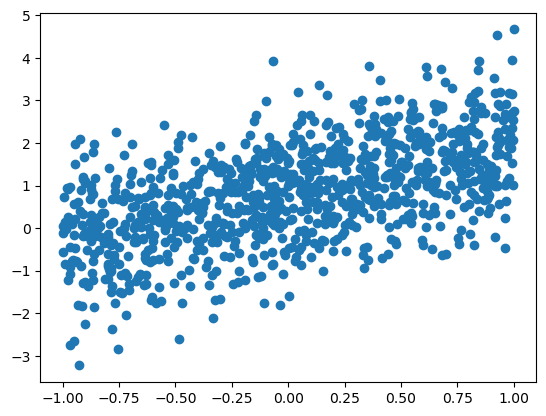

In [3]:
a0 = 0.8
b0 = 1.2

y0 = rng.normal(a0 + b0 * x, 1.0, size = n_samples)

plt.scatter(x,y0);

OLS fit

In [4]:
X = sm.add_constant(x)
model = sm.OLS(y0,X)
results = model.fit()
results.params

array([0.80362269, 1.14544601])

### Repeating the same excercise but formulated as a MLE problem

In [5]:
# log of the pdf for a normal distribution
def log_pdf(x,mu,sigma):
    return -0.5 * np.log(2.0*np.pi*sigma**2) - (x-mu)**2/(2.0*sigma**2)

In [6]:
def neg_ll_OLS(theta,y,x):
    a, b, sigma = theta
    mu = a+b*x
    return -1.0 * np.sum(log_pdf(y,mu,sigma))

In [7]:
a0_est, b0_est, sigma0_est = sp.optimize.fmin(neg_ll_OLS, (0.0, 0.0, 0.01),args=(y0,x))
a0_est, b0_est, sigma0_est 

Optimization terminated successfully.
         Current function value: 1390.658161
         Iterations: 187
         Function evaluations: 338


(0.8036425578422971, 1.1454538567828563, 0.972122287235842)

We find the same parameters a, b as before as it should.

## Heteroskedastic Errors

Now lets assume we want to model the heteroskedasiticy as $\sigma^2(X) = \exp(c+d*X)$ with unknow parameters $c$, $d$

$$Y|X \sim N(a + b * X, \exp(c + d * X))$$

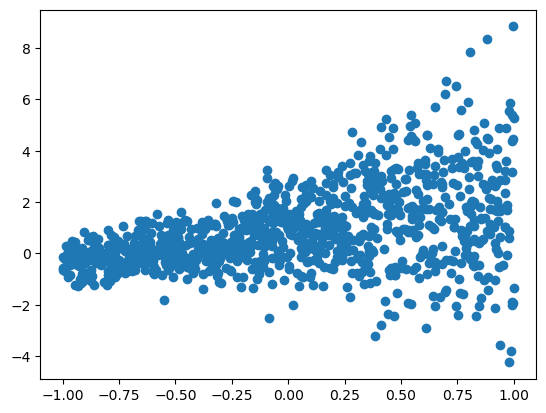

In [8]:
a1 = 0.8
b1 = 1.2

c1 = 0.1
d1 = 0.9

y = rng.normal(a1 + b1 * x, np.exp(c1 + d1 * x), size = n_samples)

plt.scatter(x,y);

### MLE fit

The MLE problem is similar as before, but for generalized sigma

In [9]:
def neg_ll_generalized(theta,y,x):
    a_mu, b_mu, a_sigma, b_sigma = theta
    mu = a_mu + b_mu * x
    sigma = np.exp(a_sigma + b_sigma * x) #take exp to ensure sigma is positve
    return -1.0 * np.sum(log_pdf(y,mu,sigma))

In [10]:
a1_est, b1_est, c1_est, d1_est = sp.optimize.fmin(neg_ll_generalized, (0.0, 0.0, 0.0, 0.0),args=(y,x))
a1_est, b1_est, c1_est, d1_est 

Optimization terminated successfully.
         Current function value: 1529.912347
         Iterations: 248
         Function evaluations: 440


(0.8485403214840227,
 1.2049933745058414,
 0.09004820094476554,
 0.9430944423086511)

In [11]:
a1, b1, c1, d1

(0.8, 1.2, 0.1, 0.9)

The fitted parameters are close to the actual parameters.

### Predictive distribution

Now we have the MLE estimates we can construct a predictive distribution for $Y$ conditioned on $X$


In [12]:
#pdf for Y|X
def pdf2(y,x,a,b,c,d):
    mu = a + b * x
    sigma = np.exp(c + d * x)

    return np.exp(-(y-mu)**2/(2.0*sigma**2))/np.sqrt(2.0*np.pi * sigma**2)

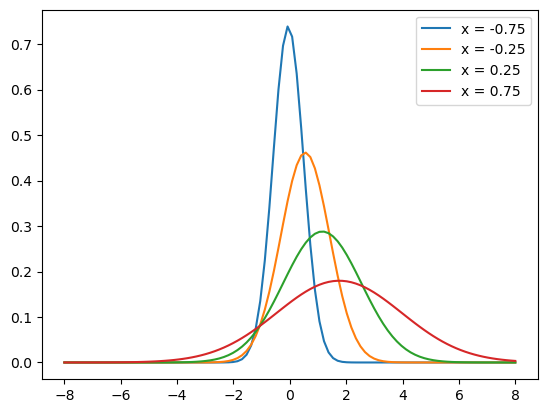

In [13]:
y_vals = np.linspace(-8,8,100)

for xi in [-0.75, -0.25, 0.25, 0.75]:
    plt.plot(y_vals, pdf2(y_vals, xi, a1_est, b1_est, c1_est, d1_est), label = F'x = {xi}')
plt.legend();

### General case

The general case, we want to model the response variable $Y$ as
$$Y|X \sim \phi(f(X), \exp(g(X)))$$
with $\phi(y;\theta)$ the probability density function and where mean and variance functions $f(X)$ and $g(X)$ can be represented as neural networks. We can find the neural network parameters by miniziming the negative log likelihood

$$\sum_i - \log(\phi(y_i; f(X_i), \exp(g(X_i))))$$

When the number of parameters we need to optimize grows, sp.optimize.fmin no longer suffices and hence we aim to find with minimum a a back-propagation problem.